In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv


# Load Model

In [15]:
query_type = 'far'
recalc = True

In [16]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")

epoch=13-val_loss=0.911523.ckpt


In [17]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [18]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_3175416/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [19]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


# Helper Functions

In [20]:
def format_transformer_input_from_batch(batch, model):
    query_states = batch['query_states'][:, None, :]
    zeros = batch['zeros'][:, None, :]
    state_seq = torch.cat([batch['context_states'], query_states], dim=1)
    action_seq = torch.cat(
        [batch['context_actions'], zeros[:, :, :model.action_dim]], dim=1)
    next_state_seq = torch.cat(
        [batch['context_next_states'], zeros[:, :, :model.state_dim]], dim=1)
    reward_seq = torch.cat([batch['context_rewards'], zeros[:, :, :1]], dim=1)
    seq = torch.cat(
        [state_seq, action_seq, next_state_seq, reward_seq], dim=2)
    seq_len = seq.shape[1]
    stacked_inputs = model.embed_transition(seq)
    return stacked_inputs

In [21]:
def format_batches(traj, context_length=1000):
    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'][:context_length])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'][:context_length])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'][:context_length])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'][:context_length])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),
        } 
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k]
        batch[k] = batch[k].to(model.device)
    baseline_batch = {}
    for k, v in batch.items():
        baseline_batch[k] = v.clone() if isinstance(v, torch.Tensor) else v
    baseline_batch['context_actions'] *= 0
    baseline_batch['context_actions'] += 0.25
    return baseline_batch, batch

In [22]:
def aggregate_token_attributions(attributions, aggregation_method='l2'):
    """
    Aggregate attributions across embedding dimensions to get token-level scores.
    
    Args:
        attributions: Attribution tensor of shape [seq_len, emb_dim]
        aggregation_method: Method to aggregate across embedding dimensions ('sum', 'l2', 'mean')
        
    Returns:
        Tensor of token-level attributions of shape [seq_len]
    """
    if aggregation_method == 'sum':
        return torch.sum(attributions, dim=-1)
    elif aggregation_method == 'l2':
        return torch.sqrt(torch.sum(attributions ** 2, dim=-1))
    elif aggregation_method == 'mean':
        return torch.mean(attributions, dim=-1)
    elif aggregation_method == 'sum-abs':
        return torch.sum(torch.abs(attributions), dim=-1)
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

# Run Gradient Attribution

In [23]:
def get_output_attributions(traj, model, action):
    baseline_batch, batch = format_batches(traj)
    layer_attributions = {}
    inputs = format_transformer_input_from_batch(batch, model)
    baseline_inputs = format_transformer_input_from_batch(baseline_batch, model)

    # Output w.r.t Input
    alphas = torch.linspace(0, 1, steps=20)
    all_grads = []
    for alpha in alphas:
        interp_input = alpha*inputs + (1-alpha)*baseline_inputs
        interp_input.requires_grad_(True)

        # Forward pass to get layer output
        transformer_output = model.transformer(inputs_embeds=interp_input)
        preds = model.pred_actions(transformer_output['last_hidden_state'])
        preds = preds[:, -1, :]
        target = preds[:, action]

        grad_wrt_input = torch.autograd.grad(
            outputs=target,
            inputs=interp_input,
            grad_outputs=target,
            retain_graph=True
        )[0]
        all_grads.append(grad_wrt_input)
    avg_grad = torch.stack(all_grads).mean(dim=0)
    avg_grad = avg_grad.detach().cpu().numpy().squeeze()
    delta_input = (inputs - baseline_inputs).detach().cpu().numpy().squeeze()
    input_to_output_attribution = np.sum(avg_grad * delta_input, axis=1)
    return input_to_output_attribution

In [24]:
def deploy_model(model, env, batch, query_state, horizon):
    if isinstance(query_state, tuple):
        query_state = list(query_state)
    elif isinstance(query_state, np.ndarray):
        query_state = query_state.tolist()
    returns = 0
    actions = []
    states = [query_state]
    for step in range(horizon):
        batch['query_states'] = convert_to_tensor(
            [np.array(query_state)]
            ).to(model.device)
        with torch.no_grad():
            action_vec = model(batch).squeeze().cpu().numpy()
        query_state, reward = env.transit(query_state, action_vec)
        actions.append(np.argmax(action_vec))
        states.append(query_state)
        returns += reward
    return returns, actions, states


In [25]:
seq_length = 200

In [30]:
if recalc:
    results = {
        'grad_val': [],
        'node_dist_from_goal': [],
        'node_dist_from_query': [],
    }
    n_iters = 2
    
    for i_eval in range(n_eval_envs):
        traj = eval_trajs[i_eval]
        first_reward_idx = np.where(traj['context_rewards'] != 0)[0]
        if (first_reward_idx.size == 0) or (first_reward_idx[0] > seq_length):
            continue
    
        env_config = {
            'maze_dim': maze_dim,
            'horizon': 200,
            'state_dim': state_dim,
            'node_encoding_corr': node_encoding_corr,
            'initialization_seed': np.array(traj['initialization_seed']).item(),
            'goal': np.array(traj['goal'])
        }
        env = DarkroomEnv(**env_config)
        _, batch = format_batches(traj, context_length=seq_length)
        optimal_action_map, dist_from_goal = env.make_opt_action_dict()
        for query_dist_from_goal in range(1, 9):
            for _ in range(n_iters):
                # Choose query state
                valid_query_states = []
                for i in range(len(traj['context_states'])):
                    test_state = traj['context_states'][i]
                    d = dist_from_goal[tuple(test_state.tolist())]
                    if d != query_dist_from_goal:
                        continue
                    returns, _, _ = deploy_model(model, env, batch, test_state, query_dist_from_goal)
                    if returns == 0:
                        continue
                    valid_query_states.append(test_state)
                if len(valid_query_states) == 0:
                    continue
                else:
                    query_state = valid_query_states[np.random.choice(len(valid_query_states))]
    
                traj['query_state'] = query_state
                query_state = query_state.tolist()
                _, dist_from_query = env._make_opt_action_dict(tuple(query_state))
                goal_state = traj['goal'].tolist()
                returns, actions, states_on_path = deploy_model(model, env, batch, query_state, query_dist_from_goal)
                attentions = get_output_attributions(traj, model, actions[0])
                max_scale = np.abs(attentions).max()
                attentions = attentions/max_scale
        
                for idx, attn in enumerate(attentions[:-1]):
                    curr_state = traj['context_states'][idx].tolist()
                    next_state = traj['context_next_states'][idx].tolist()
                    if curr_state == next_state:
                        continue
                    results['node_dist_from_goal'].append(np.mean([dist_from_goal[tuple(curr_state)], dist_from_goal[tuple(next_state)]]))
                    results['node_dist_from_query'].append(np.mean([dist_from_query[tuple(curr_state)], dist_from_query[tuple(next_state)]]))
                    results['grad_val'].append(attn)
    with open('pickles/06_integrated_gradients_by_dist_outputgrad.pkl', 'wb') as f:
        pickle.dump(results, f)
else:
    with open('pickles/06_integrated_gradients_by_dist_outputgrad.pkl', 'rb') as f:
        results = pickle.load(f)


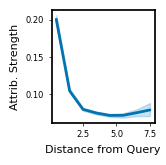

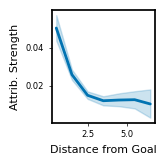

In [33]:
df = pd.DataFrame(results)
df['grad_val'] = np.abs(df['grad_val'])
plt.figure(figsize=(1.75, 1.75))

sns.lineplot(
    data=df, x='node_dist_from_query', y='grad_val',
    legend=False, linewidth=2,
)
plt.xlabel('Distance from Query', fontsize=8)
plt.ylabel('Attrib. Strength', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('figs_app/L_20B.png', dpi=300, transparent=True)
plt.savefig('figs_app/L_20B.pdf', dpi=300, transparent=True)
plt.show()

df = pd.DataFrame(results)
plt.figure(figsize=(1.75, 1.75))

sns.lineplot(
    data=df, x='node_dist_from_goal', y='grad_val',
    legend=False, linewidth=2,
)
plt.xlabel('Distance from Goal', fontsize=8)
plt.ylabel('Attrib. Strength', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('figs_app/L_20C.png', dpi=300, transparent=True)
plt.savefig('figs_app/L_20C.pdf', dpi=300, transparent=True)
plt.show()